## Import Town

In [11]:
import torch
import torch.nn as nn
from CenterLoss import FocalLoss, CenterLoss
from contextual_bandit import ContextualBandit
from Fusion_Model import FusionModel, Transformer
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
import json
import tqdm as tqdm

In [37]:
X_train, y_train = torch.load('data/X_train_simple.pt'), torch.load('data/y_train.pt')
# X_test, y_test = torch.load('data/X_test_simple.pt'), torch.load('data/y_test.pt')
cutoff = int(X_train.shape[0]*0.7)

In [38]:
X_train1, y_train1 = X_train[:cutoff, :], y_train[:cutoff]
X_val, y_val = X_train[cutoff:, :], y_train[cutoff:]
X_train, y_train = X_train1, y_train1
X_train.shape, X_val.shape

(torch.Size([20491, 64]), torch.Size([8782, 64]))

In [3]:
X_train_df = pd.read_csv('data/X_train.csv')
X_train_df['employee embedding'] = X_train_df['employee embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))
X_train_df['company embedding'] = X_train_df['company embedding'].apply(lambda x: np.array(json.loads(x), dtype=np.float64))

In [68]:
employee_embedding_tensor = torch.tensor(np.vstack(X_train_df['employee embedding'].values), dtype=torch.float64)
company_embedding_tensor = torch.tensor(np.vstack(X_train_df['company embedding'].values), dtype=torch.float64)

# Concaténer les deux tensors le long de la dimension appropriée (axis=1 pour ajouter des colonnes)
combined_tensor = torch.cat([employee_embedding_tensor, company_embedding_tensor], dim=1)

In [69]:
company_embedding_tensor.shape

torch.Size([29273, 32])

In [4]:
# Length 38 !!
#Reduce company embeddings to length 6

from sklearn.decomposition import PCA

# Création de l'objet PCA pour réduire à 6 dimensions
pca = PCA(n_components=2)

# Fit et transformation des embeddings
reduced_embeddings = pca.fit_transform(company_embedding_tensor)

# Convert embeddings columns in PyTorch tensors
plt.plot(reduced_embeddings)

NameError: name 'company_embedding_tensor' is not defined

In [5]:
def get_dataloaders(X, y, batch_size=None):
    dataset = TensorDataset(X, y)
    if batch_size is None:
        dataloader = DataLoader(dataset, batch_size=X.shape[0], shuffle=True)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

## I - Learn embddings with Transformers

In [64]:
batch_sizes = [64, 128]
num_epochs = [50]
lr = [1e-2, 1e-3]
num_layers = [2,3]

In [13]:
criterion = CenterLoss(4, 32)

In [18]:
from tqdm import tqdm

def train(data, epochs, model, lr, criterion):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losses = []
    for _ in tqdm(range(epochs)):
        running_loss = []
        for batch in data:
            X, y = batch
            optimizer.zero_grad()
            preds = model(X)
            epoch_loss = criterion(y, preds)
            epoch_loss.backward()
            optimizer.step()
            running_loss.append(epoch_loss.item())
        losses.append(np.mean(running_loss))
    return losses

In [19]:
configs = [[64,3], [128, 2], [128, 3]]

lr = 1e-3
all_losses = []

for c in configs:
    batch_size = c[0]
    layers = c[1]
    data = get_dataloaders(X_train, y_train, batch_size=batch_size)
    fusion_model = FusionModel(input_size=32, num_layers=layers, projected_size=32, hidden_size=64)
    losses = train(data, 100, fusion_model, lr, criterion=criterion)
    print(c, losses[-1])
    print(criterion(y_val, X_val))
    all_losses.append(losses)

100%|██████████| 100/100 [03:38<00:00,  2.19s/it]

[64, 3] 4.0864688302869


ValueError: Center's dim: 32 should be equal to input feature's                             dim: 64

In [49]:
torch.save(fusion_model.state_dict(), 'fusion_model_128_3.pt')

In [26]:
loss3 = train(data, 50, fusion_model, lr=1e-4, criterion=criterion)

100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


In [29]:
loss3

[3.514548449501442,
 3.504220640547922,
 3.536441088836884,
 3.508578128903826,
 3.492154324908866,
 3.502282463501547,
 3.4938155672631903,
 3.4959589343204676,
 3.48669848449505,
 3.4703983192874635,
 3.484599164713209,
 3.45354353713098,
 3.451995211969655,
 3.4761943494048073,
 3.478061736929825,
 3.4513697787608684,
 3.448428828025533,
 3.4677632482623757,
 3.446283438866755,
 3.46075810895902,
 3.4604430423347377,
 3.4593453318159155,
 3.4220022609300704,
 3.417161645547623,
 3.4168211633913983,
 3.4011964786832576,
 3.4540712306061265,
 3.4176986596294654,
 3.4183429115657864,
 3.423566718710546,
 3.41101929740371,
 3.413456883757285,
 3.3732487555604855,
 3.393179392331857,
 3.3988609793030213,
 3.4101002454014955,
 3.391831470427112,
 3.391446067165363,
 3.373445906371714,
 3.373295479103041,
 3.3708350561860936,
 3.3631226329417245,
 3.3669623764133156,
 3.3670143481355588,
 3.3697681530985135,
 3.3632313824516964,
 3.3510595556360165,
 3.3698791997083624,
 3.3350309075967544

In [53]:
torch.save(fusion_model.state_dict(), 'fusion_model_128_3.pt')

## II - Classification with Transformers / save embeddings: one balanced data vs. unbalanced data

In [71]:
fusion_model = FusionModel(input_size=32, num_layers=3, projected_size=32, hidden_size=64)
fusion_model.load_state_dict(torch.load('fusion_model_128_3.pt'))
fusion_model.eval()
X = fusion_model(combined_tensor.float())

In [72]:
data = get_dataloaders(X_train, y_train, batch_size=128)
loss3 = train(data, 20, fusion_model, lr=1e-3, criterion=criterion)

In [73]:
loss3

[10.94424429295226,
 5.511016998231781,
 5.227067514976359,
 5.061503479939811,
 4.9524399952858875,
 4.898824012057381,
 4.765509740166042,
 4.715088676962053,
 4.5693558491535065,
 4.5272803010407445,
 4.526469335792968,
 4.45879327714073,
 4.333319986829106,
 4.299783123205907,
 4.1976416214652685,
 4.138528150431117,
 4.0495986146216065,
 3.995233674967511,
 3.96949491293534,
 3.9334448102098074]

In [ ]:
loss3 = train(data, 20, fusion_model, lr=1e-3, criterion=criterion)

In [30]:
criterion(y_val, fusion_model(X_val))

tensor([6.6477], grad_fn=<CenterlossFuncBackward>)

In [4]:
# Binary classification

encoding_map = {
        0: 0,
        1: 0,
        2: 1,
        3: 1,
    }

yi = np.array([encoding_map[category.item()] for category in y_train])
yi = torch.tensor(yi)

In [5]:
transformer = Transformer(2, 128, 64, 2, 4, classification_head=True)
data = get_dataloaders(X_train, yi, batch_size=64)

In [35]:
x = torch.randn(128, 1, 4)
x[:, 0, :].shape

torch.Size([128, 4])

In [51]:
loss_g0 = FocalLoss(alpha = 0.3, gamma = 0)
loss_g1 = FocalLoss(alpha = 0.7, gamma = 0)
loss_g2 = FocalLoss(alpha = -1, gamma=0)

criterions = [loss_g0, loss_g1, loss_g2]

In [35]:
X_train.shape

torch.Size([20491, 32])

In [41]:
X = fusion_model(X_train)
X = X.detach()

In [42]:
X.shape

torch.Size([20491, 32])

In [43]:
encoding_map = {
        0: 1,
        1: 1,
        2: 1,
        3: 1,
    }

dataloaders = []
data_X = X_train

for i in range(3):
    encoding_map[i] = 0
    yi = [encoding_map[category.item()] for category in y_train]
    yi = torch.tensor(yi)
    dataloaders.append(get_dataloaders(X, yi, batch_size=128))

In [44]:
params_Transformer = {
    'num_classes': 2,
    'hidden_size': 128,
    'input_size': 32,
    'num_layers': 3,
    'n_head': 4,
    'type': 'Transformer'
}

In [150]:
combined_tensor.shape[1]

64

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(emb)
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
f1_score(y_pred, y_val, average='macro')

/Users/juliette/anaconda3/envs/compstat/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [62]:
heads = [8]
num_layers = [2]
hidden_size = [128]

params = [params_Transformer, params_Transformer, params_Transformer]

params[0]['n_head'] = 4
params[0]['num_layers'] = 2
params[0]['hidden_size'] = 12

params[1]['n_head'] = 4
params[1]['num_layers'] = 2
params[1]['hidden_size'] = 12

params[2]['n_head'] = 4
params[2]['num_layers'] = 2
params[2]['hidden_size'] = 12

bandit = ContextualBandit(3, 32, params=params, epochs=[20, 20, 20], criterions=criterions)
bandit.initialize(dataloaders)

0


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


Final loss:  0.12222723010348978
F1 score:  0.8952380952380952
1


100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Final loss:  0.13048678372772585
F1 score:  1.0
2


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]

Final loss:  0.1628727257853339
F1 score:  1.0


In [68]:
preds = []
emb = fusion_model(X_val).detach()
for i in range(emb.shape[0]):
    val = emb[i, :]
    pred = bandit.select_arm(val)
    preds.append(pred)

KeyboardInterrupt: 

In [ ]:
# preds = torch.argmax(torch.tensor(preds), dim=1)
pd.Series(preds).value_counts()

3    8677
0     105
Name: count, dtype: int64

([<matplotlib.axis.YTick at 0x19ea73e90>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2'), Text(0, 3.5, '3')])

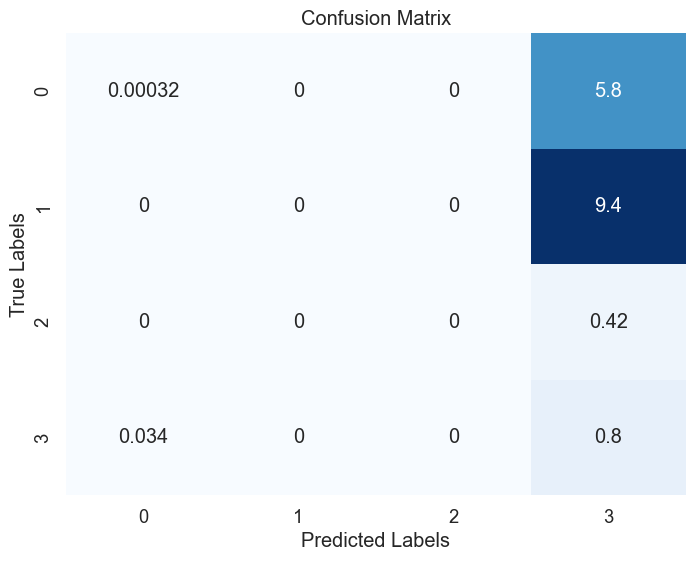

In [65]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val, preds)

conf_matrix = conf_matrix.astype(float) 
conf_matrix /= np.sum(conf_matrix, axis = 1)
conf_matrix.diagonal()

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability

# Create heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False)

# Set labels, title, and axis ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(conf_matrix))+0.5, labels=np.arange(len(conf_matrix)))
plt.yticks(ticks=np.arange(len(conf_matrix))+0.5, labels=np.arange(len(conf_matrix)))

In [66]:
f1_score(preds, y_val, average = 'macro')

0.023188045945470425

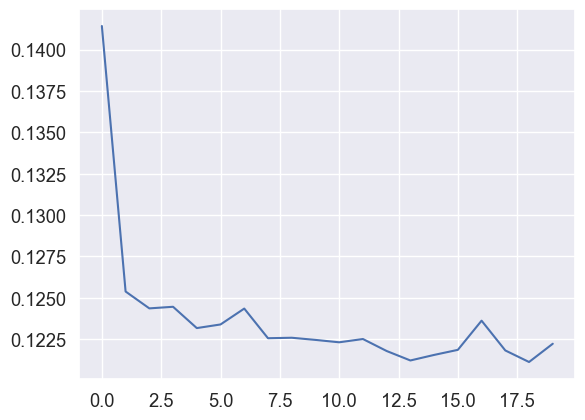

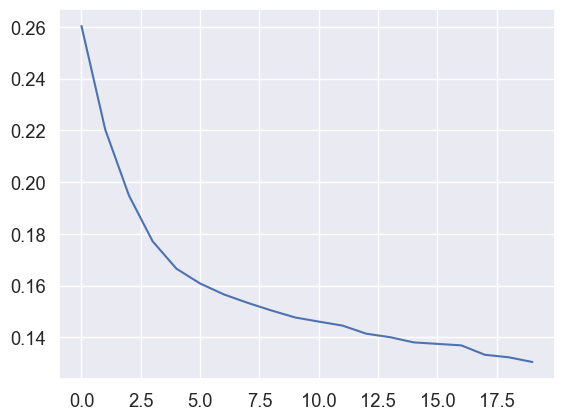

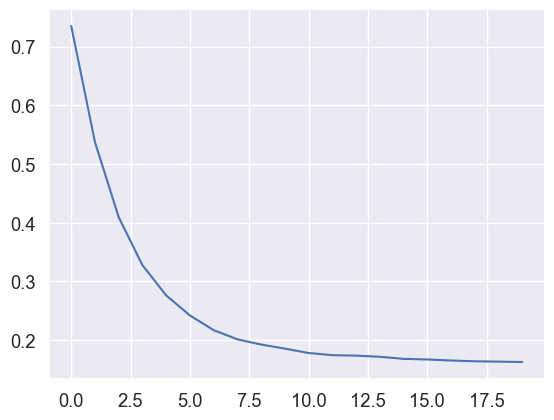

In [67]:
import numpy as np

for i in range(3):
    losses = np.load('losses'+str(i)+ '.npy')
    plt.plot(losses)
    plt.show()

III - Binary classification with Transformers and Focal Loss